In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

In [78]:
djia = pd.read_excel('/Users/zhouruohe/Downloads/DJIA.xlsx')[['Date','Close*']].sort_values(by='Date')

In [79]:
djia.head()

,Date,Close*
7532,1992-11-17,3193.3
7531,1992-11-18,3207.4
7530,1992-11-19,3209.5
7529,1992-11-20,3227.4
7528,1992-11-23,3223.0


In [80]:
djia['20d moving average'] = djia['Close*'].rolling(window=20).mean()
djia['40d moving average'] = djia['Close*'].rolling(window=40).mean()
djia['60d moving average'] = djia['Close*'].rolling(window=60).mean()
djia['90d moving average'] = djia['Close*'].rolling(window=90).mean()

In [81]:
djia.dropna(inplace=True)

In [82]:
djia.head()

,Date,Close*,20d moving average,40d moving average,60d moving average,90d moving average
7443,1993-03-26,3439.98,3439.4755,3401.93575,3360.384833,3335.048778
7442,1993-03-29,3455.10,3444.4600,3405.56325,3362.951333,3337.957667
7441,1993-03-30,3457.27,3447.2970,3408.69000,3365.419167,3340.734000
7440,1993-03-31,3435.11,3448.8505,3411.35025,3367.539333,3343.240778
7439,1993-04-01,3439.44,3450.8770,3412.99125,3369.776667,3345.596778


Text(0.5, 1.0, '90 Day Moving Average')

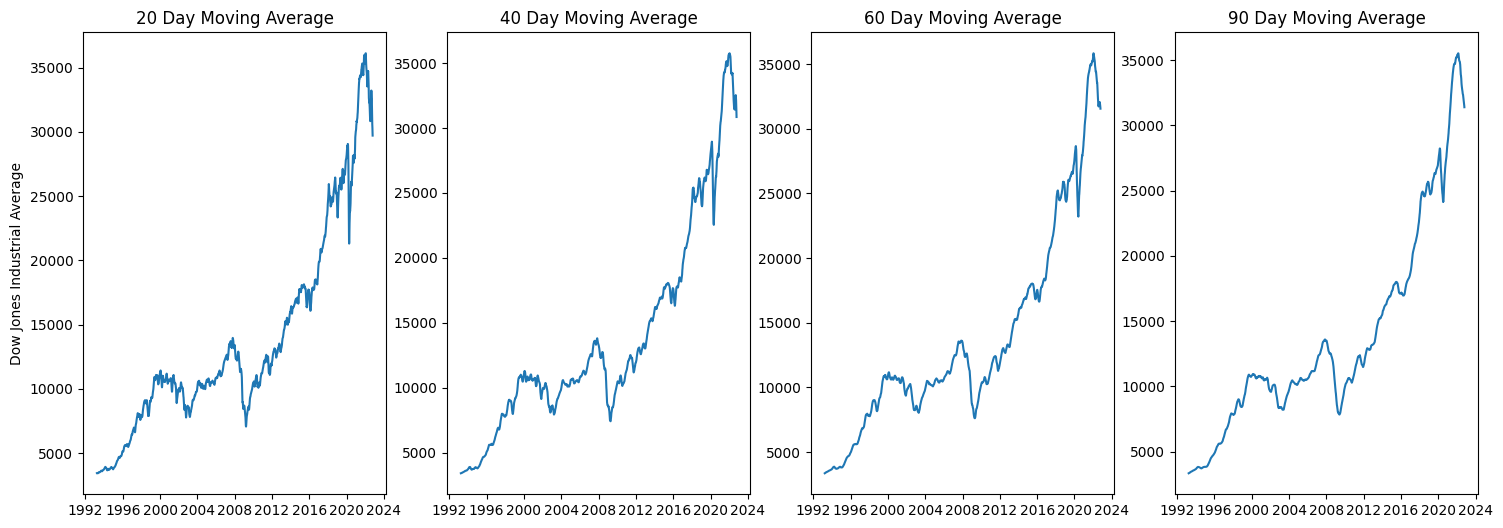

In [83]:
fig, axes = plt.subplots(1, 4, figsize=(18,6))
axes[0].plot(djia['Date'], djia['20d moving average'])
axes[0].set_ylabel('Dow Jones Industrial Average')
axes[0].set_title('20 Day Moving Average')
axes[1].plot(djia['Date'], djia['40d moving average'])
axes[1].set_title('40 Day Moving Average')
axes[2].plot(djia['Date'], djia['60d moving average'])
axes[2].set_title('60 Day Moving Average')
axes[3].plot(djia['Date'], djia['90d moving average'])
axes[3].set_title('90 Day Moving Average')

In [84]:
djia = djia.set_index('Date')

In [85]:
djia_close = djia['Close*']

In [86]:
fig = px.area(djia_close, title='Close Price Trend')
fig.show()

### Create Time Features

In [87]:
djia = djia.reset_index()

In [88]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [104]:
X1 = create_features(djia)
X1.head()

/var/folders/nr/r7m_ksxd1zj2ttsw9nprxcv00000gn/T/ipykernel_83085/1506493648.py:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,0,4,1,3,1993,85,26,12
1,0,0,1,3,1993,88,29,13
2,0,1,1,3,1993,89,30,13
3,0,2,1,3,1993,90,31,13
4,0,3,2,4,1993,91,1,13


### Time Series Cross Validation

In [105]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array(X1)
y = np.array(djia['60d moving average'])
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
X_train, X_test = np.vstack(X[train_index]), np.vstack(X[test_index])
y_train, y_test = np.vstack(y[train_index]), np.vstack(y[test_index])

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [   0    1    2 ... 1241 1242 1243] TEST: [1244 1245 1246 ... 2481 2482 2483]
TRAIN: [   0    1    2 ... 2481 2482 2483] TEST: [2484 2485 2486 ... 3721 3722 3723]
TRAIN: [   0    1    2 ... 3721 3722 3723] TEST: [3724 3725 3726 ... 4961 4962 4963]
TRAIN: [   0    1    2 ... 4961 4962 4963] TEST: [4964 4965 4966 ... 6201 6202 6203]
TRAIN: [   0    1    2 ... 6201 6202 6203] TEST: [6204 6205 6206 ... 7441 7442 7443]


### XGBoost

In [124]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error as MSE
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

/usr/local/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [125]:
y_pred = reg.predict(X_test)
rmse = np.sqrt(MSE(y_test, y_pred))
print("RMSE : % f" %(rmse))

RMSE :  8541.091765


In [126]:
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = ['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']
X_test_df.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,0,4,4,11,2017,314,10,45
1,0,0,4,11,2017,317,13,46
2,0,1,4,11,2017,318,14,46
3,0,2,4,11,2017,319,15,46
4,0,3,4,11,2017,320,16,46


In [127]:
from datetime import date
DATE = []
for y, m, d in zip(X_test_df['year'],X_test_df['month'], X_test_df['dayofmonth']):
    DATE.append(date(y, m, d))
X_test_df['Date'] = DATE
X_test_df.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Date
0,0,4,4,11,2017,314,10,45,2017-11-10
1,0,0,4,11,2017,317,13,46,2017-11-13
2,0,1,4,11,2017,318,14,46,2017-11-14
3,0,2,4,11,2017,319,15,46,2017-11-15
4,0,3,4,11,2017,320,16,46,2017-11-16


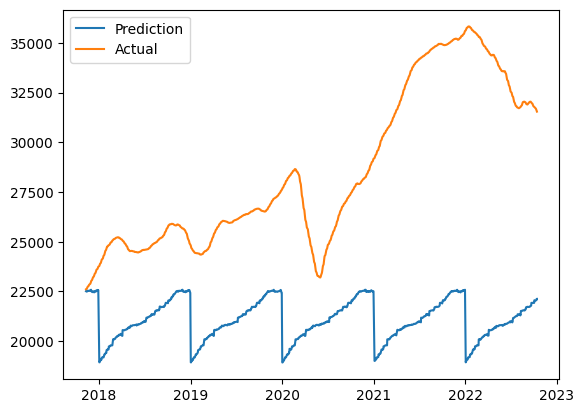

In [128]:
plt.plot(X_test_df['Date'], y_pred, label = 'Prediction')
plt.plot(X_test_df['Date'], y_test, label = 'Actual')
plt.legend()

### Random Forest

In [130]:
y_pred

array([22510.19 , 22489.404, 22500.479, ..., 22058.1  , 22125.604,
       22125.986], dtype=float32)

In [131]:
prediction

array([22562.83155   , 22553.46063333, 22553.46063333, ...,
       22085.75316667, 22100.15406667, 22100.15406667])

In [132]:
from sklearn.ensemble import RandomForestRegressor
# # of trees and create Random Forest model
rfc = RandomForestRegressor(n_estimators=10) 
rfc
rfc.fit(X_train, y_train)
# Predict target data using Test data 
prediction = rfc.predict(X_test)
# Compare prediction and real test data
print (prediction==y_test)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


/var/folders/nr/r7m_ksxd1zj2ttsw9nprxcv00000gn/T/ipykernel_83085/373809709.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [137]:
rmse = np.sqrt(MSE(y_test, prediction))
print("RMSE : % f" %(rmse))

RMSE :  8544.988057


### Comparison of XGBOOST and Random Forest

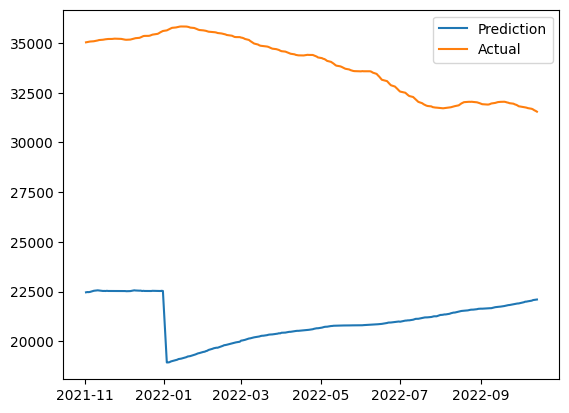

In [135]:
plt.plot(X_test_df['Date'][1000:], prediction[1000:], label = 'Prediction')
plt.plot(X_test_df['Date'][1000:], y_test[1000:], label = 'Actual')
plt.legend()

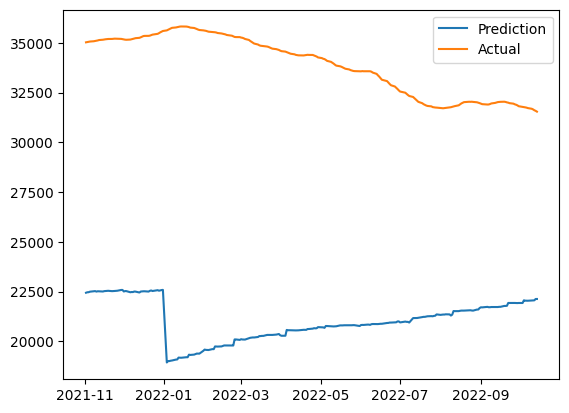

In [136]:
plt.plot(X_test_df['Date'][1000:], y_pred[1000:], label = 'Prediction')
plt.plot(X_test_df['Date'][1000:], y_test[1000:], label = 'Actual')
plt.legend()

### ARIMA

In [20]:
djia.head()
df_arima = djia[['Date','90d moving average']]
df_arima['Month'] = pd.to_datetime(df_arima['Date'])
df_arima = df_arima[['Month','90d moving average']]
df_arima = df_arima.set_index('Month')
df_arima.head()

/var/folders/nr/r7m_ksxd1zj2ttsw9nprxcv00000gn/T/ipykernel_83085/2884145774.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,90d moving average
Month,
1993-03-26,3335.048778
1993-03-29,3337.957667
1993-03-30,3340.734000
1993-03-31,3343.240778
1993-04-01,3345.596778


In [21]:
from pmdarima.arima import auto_arima
#spilt 80% to be training dataset, and 20% for testing dataset
arima_train = df_arima[:int(len(df_arima)*0.8)]
arima_test = df_arima[-int(len(df_arima)*0.2):]
#fitting arima model
arima_model = auto_arima(arima_train, trace = True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=3.92 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=23787.086, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=23777.281, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=23776.663, Time=0.19 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=23764.369, Time=0.67 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=23776.902, Time=0.29 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=23776.958, Time=0.87 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=23775.265, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=23775.183, Time=0.23 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=23766.366, Time=1.87 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 8.570 seconds


In [22]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5955
Model:               SARIMAX(1, 2, 1)   Log Likelihood              -11879.184
Date:                Wed, 16 Nov 2022   AIC                          23764.369
Time:                        15:27:30   BIC                          23784.444
Sample:                             0   HQIC                         23771.343
                               - 5955                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9013      0.025     35.833      0.000       0.852       0.951
ma.L1         -0.9304      0.021    -43.532      0.000      -0.972      -0.888
sigma2         3.1680      0.036     87.891      0.000       3.097       3.239
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):              2550.43
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
arima_model.fit(arima_train)
forcast = arima_model.predict(n_periods = len(arima_test))
arima_predict = pd.DataFrame(dict(Date = arima_test.reset_index()['Month'], s2 =  pd.DataFrame(forcast).reset_index()[0])).set_index('Date')
arima_predict.head()
arima_predict = arima_predict.reset_index()
# forcast = pd.DataFrame(forcast, index = arima_test.index, columns = ['prediction'])

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



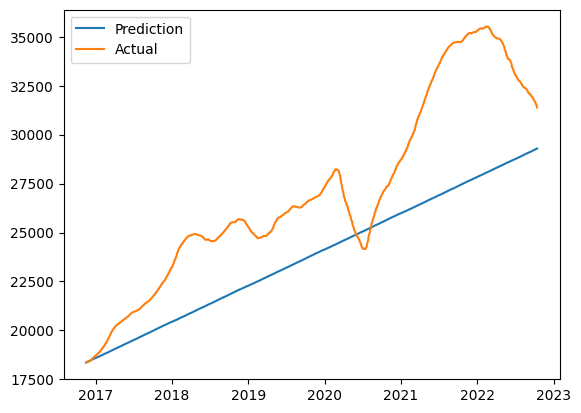

In [24]:
plt.plot(arima_predict['Date'], arima_predict['s2'], label = 'Prediction')
plt.plot(arima_predict['Date'], arima_test['90d moving average'], label = 'Actual')
plt.legend()

In [25]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(arima_predict['s2'], arima_test['90d moving average'],squared=False)
rmse

3894.6102658380883

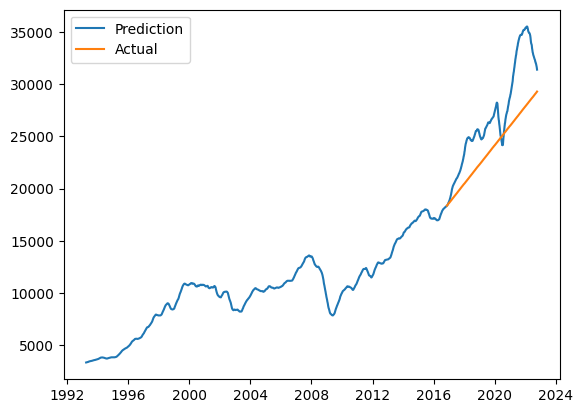

In [26]:
l1 = arima_train.reset_index()
l1.columns = ['Date', '90d moving average']
l2 = arima_predict
l2.columns = ['Date', '90d moving average']
l3 = arima_test.reset_index()
l3.columns = ['Date', '90d moving average']
k1 = pd.concat([l1, l2], axis = 0)
k2 = pd.concat([l1, l3], axis = 0)
plt.plot(k2['Date'], k2['90d moving average'], label = 'Prediction')
plt.plot(arima_predict['Date'], l2['90d moving average'], label = 'Actual')
plt.legend()

### LSTM

In [27]:
df = pd.read_excel('/Users/zhouruohe/Downloads/DJIA.xlsx')[['Date','Close*']].sort_values(by='Date')
df.set_index(keys='Date',inplace=True)
df.dropna(inplace = True)
df.head()

,Close*
Date,
1992-11-17,3193.3
1992-11-18,3207.4
1992-11-19,3209.5
1992-11-20,3227.4
1992-11-23,3223.0


In [28]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-11-16 15:27:33.475036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0, 0.5, 'Prices ($)')

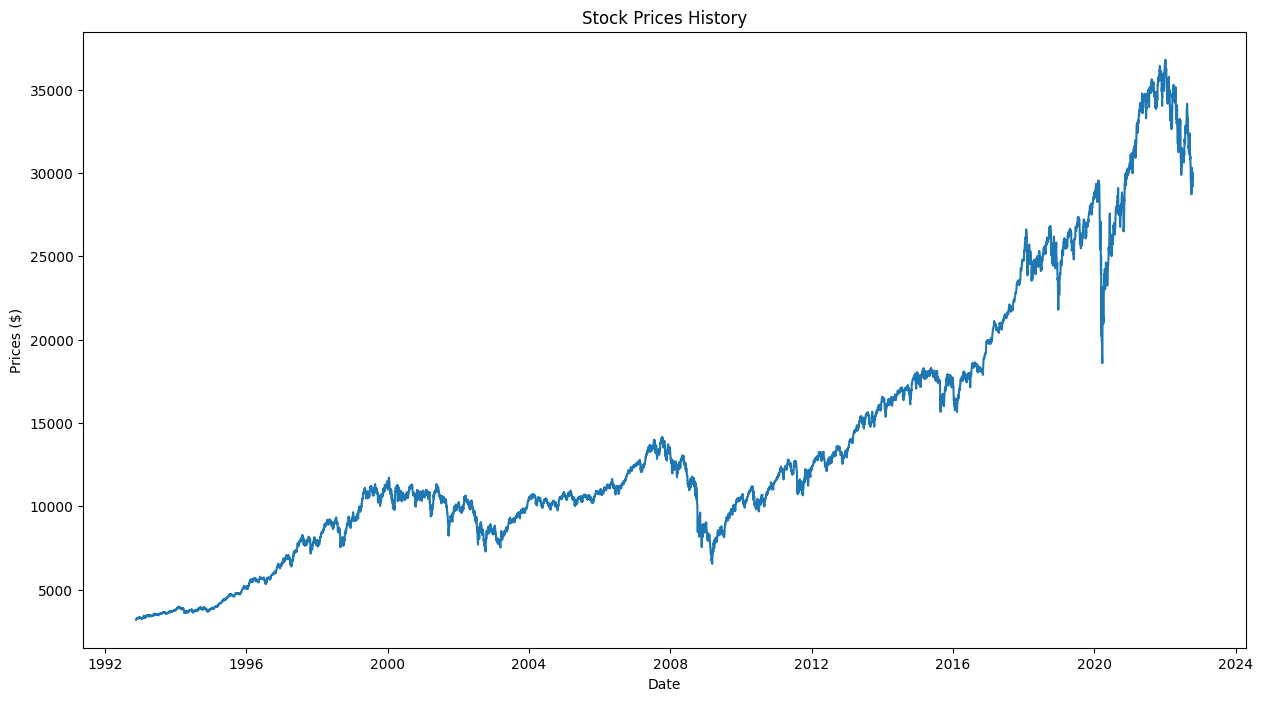

In [29]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close*'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [30]:
close_prices = df['Close*']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [31]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [32]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

2022-11-16 15:27:59.926581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
5967/5967 [==============================] - 198s 32ms/step - loss: 1.7629e-04
Epoch 2/3
5967/5967 [==============================] - 191s 32ms/step - loss: 8.1177e-05
Epoch 3/3
5967/5967 [==============================] - 186s 31ms/step - loss: 5.1895e-05


In [34]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

48/48 [==============================] - 3s 36ms/step


411.8767701070725

/var/folders/nr/r7m_ksxd1zj2ttsw9nprxcv00000gn/T/ipykernel_83085/2071224294.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



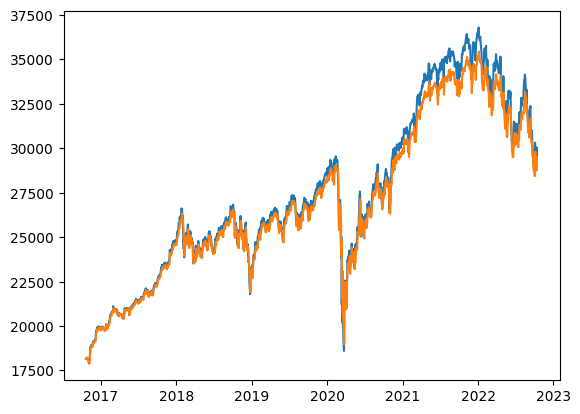

In [35]:
data = df.filter(['Close*'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.plot(validation[['Close*']])
plt.plot(validation[[ 'Predictions']])